In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# compute numerically integrals of general functions, using Interpolatory quadrature rules

$$\int_a^b f(x) dx \sim \sum_{i=0}^{n-1} f(q_i) w_i = \int_a^b I^{n-1}(f) = \int_a^b\sum_{i=0}^{n-1}f(q_i) l_i(x) dx = \sum_{i=0}^{n-1}f(q_i) \int_a^b l_i(x) dx$$

$$
w_i := \int_a^b l_i(x) dx
$$
where $l_i$ are the Lagrange basis functions associated to $\{q_i\}_{i=0}^{n-1}$.

The definition of $l_i$:

$$
l_i := \prod_{i\neq j, j=0}^{n-1} \frac{(x-q_j)}{(q_i-q_j)}
$$

In [130]:
N = 101
x = linspace(0,1, N)

In [8]:
def lagrange(x, q, i):
    assert i < len(q)
    li = ones_like(x)
    for j in range(len(q)):
        if i != j:
            li = li*(x-q[j])/(q[i]-q[j]) 
    return li

[[<matplotlib.lines.Line2D at 0x7fa770943bb0>],

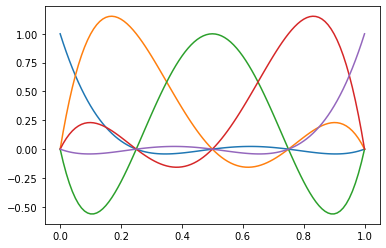

In [15]:
Nq = 5
q = linspace(0,1, Nq)

[plot(x, lagrange(x, q, i)) for i in range(5)]

With the monomial basis $\{v_i\}_{i=0}^{n-1} := \{x^i\}_{i=0}^{n-1}$, we can rewrite the lagrange basis as

$$
l_i = V^{ij} v_j
$$

where $V_{ij} = v_j(q_i)$, and $V^{ij}$ is the $ij$ index of the inverse matrix of $V_{ij}$

In [17]:
def monomial(x, i):
    return x**i

In [20]:
V = array([monomial(q,i) for i in range(Nq)]).T

In [23]:
Vinv = linalg.inv(V)

$$
M_{\alpha i} := v_i(x_\alpha) = pow(x_\alpha,i)
$$

$$
L_{\alpha j}:= M_{\alpha i} V^{ij} := l_j(x_\alpha)
$$

In [34]:
M = array([monomial(x,i) for i in range(Nq)]).T

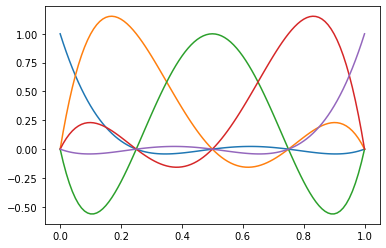

In [35]:
L = M.dot(Vinv)

plot(x, L)

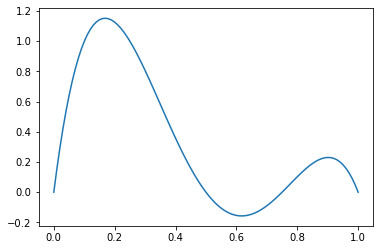

In [40]:
# express basis with index 1 in power basis
plot(x, M.dot(Vinv[:,1]))

In [41]:
Vinv[:,1]

array([  0.        ,  16.        , -69.33333333,  96.        ,
       -42.66666667])

If we have the monomial coefficients, we can write the integral of the monomials explicitly:

$$
\int_a^b x^i = \left.\frac{x^{(1+1)}}{i+1} \right|^{b}_a
$$

Lets define the vector 
$$
\{W_i\}_{i=0}^{n-1} := \left\{\int_a^b x^i\right\}_{i=0}^{n-1}
$$
then the integral of a polynomial can be written as:
$$
\int_a^b \sum_i p^i x^{i} = \sum p_i W_i
$$

In [42]:
def integral_of_monomials(a,b, i):
    assert i >= 0
    return (b**(i+1)-a**(i+1))/(i+1)

In [44]:
W = array([integral_of_monomials(0,1,i) for i in range(Nq)])

In [54]:
# Now compute w_i, which is the integral of l_i:
w = W.dot(Vinv)

In [55]:
w

array([0.07777778, 0.35555556, 0.13333333, 0.35555556, 0.07777778])

In [56]:
def weights_of_quadrature_rule(q,a,b):
    Nq = len(q)
    V = array([q**i for i in range(Nq)]).T
    Vinv = linalg.inv(V)
    W = array([integral_of_monomials(a,b,i) for i in range(Nq)])
    w = W.dot(Vinv)
    return w

In [73]:
q = linspace(-1,1, Nq)
w = weights_of_quadrature_rule(q, -1, 1)

Let's check basic identities:

$$
\int_a^b p = \sum_{i=0}^{n-1} p(q_i) w_i \qquad \forall p \in P^{k}(a,b), \quad k
\le n-1
$$

In [74]:
def error_on_monomial(q,w,a,b,i):
    exact = integral_of_monomials(a,b,i)
    computed = (q**i).dot(w)
    return abs(exact-computed)

error = array([error_on_monomial(q,w,-1,1,i) for i in range(2*Nq)])

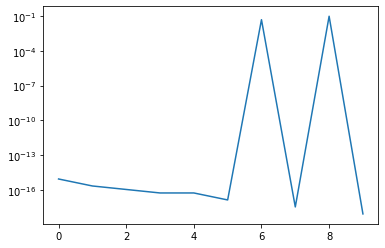

In [75]:
semilogy(error)

Gauss quadrature rules are the "optimal" ones: they are exact up to $k=2n-1$

In [76]:
qg, wg = numpy.polynomial.legendre.leggauss(Nq)

In [79]:
errorg = array([error_on_monomial(qg,wg,-1,1,i) for i in range(2*Nq+2)])

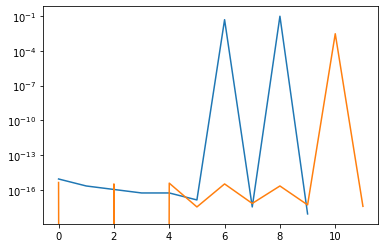

In [80]:
semilogy(error)
semilogy(errorg)

In [93]:
a = 0
b = 1
Nq = 5

# Rescale gauss quadrature between a and b
qg, wg = numpy.polynomial.legendre.leggauss(Nq)
qg = (qg+1)*(b-a)/2+a
wg = wg/2*(b-a)

q = linspace(a,b, Nq)
w = weights_of_quadrature_rule(q, a, b)

In [103]:
def myfun(x):
    return sin(pi*x)

def myintegral():
    return 2/pi

In [143]:
def difference_between_formulas(N,a,b,myfun,myintegral):
    assert N >=1
    errors = zeros((N-1, 4))
    for Nq in range(1,N):
        # Rescale gauss quadrature between a and b
        qg, wg = numpy.polynomial.legendre.leggauss(Nq)
        qg = (qg+1)*(b-a)/2+a
        wg = wg/2*(b-a)
        
        # Chebyshev points
        qc, wc = numpy.polynomial.chebyshev.chebgauss(Nq)
        qc = (qc+1)*(b-a)/2+a
        wc = weights_of_quadrature_rule(qc, a, b)

        # Equispaced points
        q = linspace(a,b, Nq)
        w = weights_of_quadrature_rule(q, a, b)
        
        # "Averaged" mid point, or iterated trapezoidal
        wa = ones_like(q)/(len(q))*(b-a)
        
        index = Nq-1
        errors[index, 0] = abs(myfun(q).dot(w)-myintegral())
        errors[index, 1] = abs(myfun(qc).dot(wc)-myintegral())
        errors[index, 2] = abs(myfun(qg).dot(wg)-myintegral())
        errors[index, 3] = abs(myfun(q).dot(wa)-myintegral())
    return errors

In [152]:
errors = difference_between_formulas(`, 0, 1, myfun, myintegral)

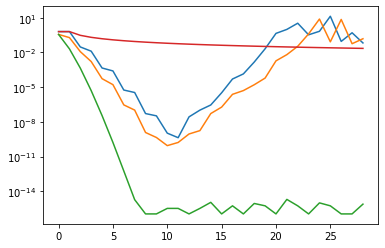

In [153]:
semilogy(errors)

In [146]:
def absfun(x):
    return 2*abs(x-.5)

def absintegral():
    return 0.5

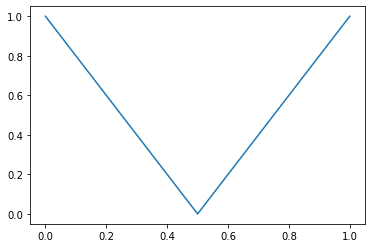

In [147]:
plot(x, absfun(x))

In [150]:
errors = difference_between_formulas(30, 0, 1, absfun, absintegral)

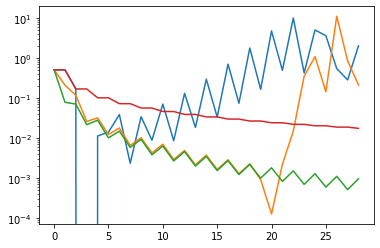

In [151]:
semilogy(errors)